# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Thursday, June 18, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1So8HLNQZmdKkKVhrvCBym6cYSKHkpU_d?usp=sharing

In [2]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt 

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [3]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [4]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [5]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [6]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [7]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [8]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [9]:
# 'vals' dictionary to store min, max and avg for each column
vals = {}
cols = ["age", "yredu", "capgain", "caploss", "workhr"]

# find min, max and avg for each column
for col in cols:
  min_val = df[col].min()
  max_val = df[col].max()
  avg_val = df[col].mean()
  vals[col] = [min_val, max_val, avg_val]

# print values
for i in vals:
  print(i)
  print("\tmin: %s" %(vals[i][0]))
  print("\tmax: %s" %(vals[i][1]))
  print("\tavg: %s" %(vals[i][2]))

# normalize features
for col in cols:
  df[col] = df[col] / vals[col][1]

age
	min: 17
	max: 90
	avg: 38.58164675532078
yredu
	min: 1
	max: 16
	avg: 10.0806793403151
capgain
	min: 0
	max: 99999
	avg: 1077.6488437087312
caploss
	min: 0
	max: 4356
	avg: 87.303829734959
workhr
	min: 1
	max: 99
	avg: 40.437455852092995


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [10]:
# hint: you can do something like this in pandas
males = sum(df["sex"] == " Male")
females = sum(df["sex"] == " Female")
tot = males + females

print("%s males\t\t%s females" % (males, females))
print("%f%% males\t%f%% females" % (males/tot*100, females/tot*100))


21790 males		10771 females
66.920549% males	33.079451% females


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [11]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [12]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

print("%d record contained missing features" %(len(df_with_missing)))
print("%f%% records were removed" %(100*len(df_with_missing)/(len(df_with_missing) + len(df_not_missing))))

1843 record contained missing features
5.660146% records were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [13]:
jobs = set(df_not_missing["work"])

print(jobs)

{' Self-emp-not-inc', ' Without-pay', ' Local-gov', ' Private', ' Self-emp-inc', ' Federal-gov', ' State-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [14]:
data = pd.get_dummies(df_not_missing)

In [15]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.433333,0.8125,0.02174,0.0,0.404040,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.555556,0.8125,0.00000,0.0,0.131313,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.422222,0.5625,0.00000,0.0,0.404040,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [16]:
# determine how many columns there should be after one-hot encoding
accum = 0
for i in df_not_missing.columns:
  if i in ["age",	"yredu", "capgain",	"caploss",	"workhr"]:
    accum = accum + 1 # column has numerical values between 0 and 1 (e.g. age)
  else:
    accum = accum + len(set(df_not_missing[i])) # column has string values -> need to use one-hot encoding
print("after one-hot encoding, there will be %d columns" %accum)

# determine number of columns in 'data' dataframe
ncols = len(data.columns)
print("there are %d columns in 'data' dataframe" %ncols)

'''
with one-hot encoding, any column that has string values needs to be converted into a series of columns where the value is either 0 or 1.
grouped together, these columns are a binary representation of the particular column's catagory values.
'''

after one-hot encoding, there will be 57 columns
there are 57 columns in 'data' dataframe


"\nwith one-hot encoding, any column that has string values needs to be converted into a series of columns where the value is either 0 or 1.\ngrouped together, these columns are a binary representation of the particular column's catagory values.\n"

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [17]:
datanp = data.values.astype(np.float32)

In [18]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    
    ind = np.argmax(onehot)
    values = cat_values[feature]
    return values[ind]

In [19]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [20]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

np.random.shuffle(datanp)

train_index = int(datanp.shape[0] * 0.7)
val_index = int(datanp.shape[0] * 0.85)

train_set = datanp[:train_index]
val_set = datanp[train_index:val_index]
test_set = datanp[val_index:]

print("# Train Set: " + str(train_set.shape[0]))
print("# Test Set: " + str(val_set.shape[0]))
print("# Val Set: " + str(test_set.shape[0]))

# Train Set: 21502
# Test Set: 4608
# Val Set: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [21]:
from torch import nn

torch.manual_seed(1000) # set the random seed

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 42),
            nn.ReLU(),
            nn.Linear(42, 27),
            nn.ReLU(),
            nn.Linear(27, 11),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 27),
            nn.ReLU(),
            nn.Linear(27, 42),
            nn.ReLU(),
            nn.Linear(42, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [22]:
'''
The values inside the data frame 'data' are all normalized to be between 0 and 1.
The sigmoid activation maps the values in the output nodes to be between 0 to 1.
'''

"\nThe values inside the data frame 'data' are all normalized to be between 0 and 1.\nThe sigmoid activation maps the values in the output nodes to be between 0 to 1.\n"

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [23]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    i = 1

    print("COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS")

    for epoch in range(num_epochs):
        for data in train_loader:
            if use_cuda and torch.cuda.is_available():
              data = data.cuda()
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        tmp_acc, tmp_loss = evaluate(model, train_loader, criterion)
        train_acc += [tmp_acc]
        train_loss += [tmp_loss]
        tmp_acc, tmp_loss = evaluate(model, valid_loader, criterion)
        val_acc += [tmp_acc]
        val_loss += [tmp_loss]

        print("%d \t\t %10.9f \t\t %10.7f \t\t %10.9f \t\t %10.7f" % (i, train_acc[-1], train_loss[-1], val_acc[-1], val_loss[-1]))
        i += 1

    n = len(train_acc) # number of epochs

    plt.title("Model Loss")
    plt.plot(range(1,1+n), train_loss, label="Train")
    plt.plot(range(1,1+n), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    print("Final Training Loss: {}".format(train_loss[-1]))
    print("Final Validation Loss: {}".format(val_loss[-1]))

    plt.title("Model Accuracy")
    plt.plot(range(1,1+n), train_acc, label="Train")
    plt.plot(range(1,1+n), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [24]:
def evaluate(model, data_loader, criterion):
    """ Return the accuracy and loss of the model across a dataset
    """

    total_loss = 0.0
    acc = 0.0
    total = 0.0
    i=0

    for col in catcols:
        for item in data_loader: # minibatches
            if use_cuda and torch.cuda.is_available():
              item = item.cuda()
            out = model(zero_out_feature(item.clone(), col))
            loss = criterion(out, item) # compute loss
            total_loss += loss.item()
            i += 1
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i].cpu().detach().numpy(), col) == get_feature(item[i].cpu().detach().numpy(), col))
                total += 1

    # compute model loss
    model_loss = float(total_loss) / (i + 1)

    # compute model accuracy
    model_acc = (float(acc)) / total

    return model_acc, model_loss

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

In [25]:
# enable cuda
use_cuda = True

CUDA Available! Using GPU...
COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
1 		 0.437300406 		  4.4949474 		 0.436197917 		  0.9338996
2 		 0.457755868 		  2.3143435 		 0.456958912 		  0.4805707
3 		 0.461631476 		  2.2855667 		 0.460431134 		  0.4745902
4 		 0.459709174 		  2.2616915 		 0.458550347 		  0.4695862
5 		 0.460701330 		  2.2246090 		 0.459888600 		  0.4617728
6 		 0.484024742 		  2.0967592 		 0.482602720 		  0.4349367
7 		 0.531935014 		  1.8555551 		 0.532624421 		  0.3845279
8 		 0.545902707 		  1.8041478 		 0.546657986 		  0.3738770
9 		 0.556552879 		  1.7757335 		 0.556061921 		  0.3679072
10 		 0.561684184 		  1.7533187 		 0.561957465 		  0.3631882
11 		 0.569009084 		  1.7268521 		 0.569769965 		  0.3575132
12 		 0.572419620 		  1.7046473 		 0.572337963 		  0.3528610
13 		 0.571853781 		  1.6820867 		 0.571542245 		  0.3480651
14 		 0.573574551 		  1.6573929 		 0.572627315 		  0.3428454
15 		 0.573714073 		  1.6280736 		 0.57

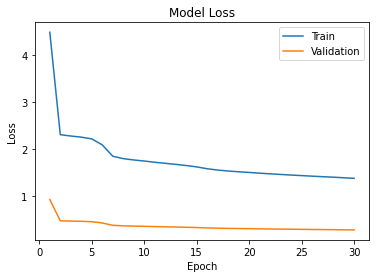

Final Training Loss: 1.3850842511221286
Final Validation Loss: 0.28659090906148776


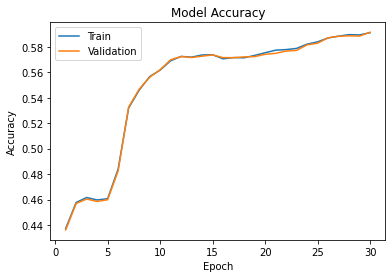

Final Training Accuracy: 0.5910380429727468
Final Validation Accuracy: 0.5913990162037037


In [ ]:
batch_size=64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1, shuffle=True)

autoencoder = AutoEncoder()
if use_cuda and torch.cuda.is_available():
    autoencoder = autoencoder.cuda()
    print("CUDA Available! Using GPU...")

train(autoencoder, train_loader, valid_loader, num_epochs=30, learning_rate=1e-4)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

CUDA Available! Using GPU...
COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
1 		 0.457182278 		  9.6829845 		 0.454535590 		  1.9458334
2 		 0.459406877 		  9.4600349 		 0.458333333 		  1.9006299
3 		 0.459848696 		  9.2926736 		 0.458550347 		  1.8669022
4 		 0.453802747 		  8.7788121 		 0.452546296 		  1.7626073
5 		 0.545894956 		  7.3741120 		 0.546983507 		  1.4776672
6 		 0.571078659 		  7.1749899 		 0.570891204 		  1.4381823
7 		 0.575086039 		  7.0489666 		 0.574869792 		  1.4121869
8 		 0.578953896 		  6.9285595 		 0.578486690 		  1.3882291
9 		 0.581372275 		  6.8118747 		 0.579535590 		  1.3650803
10 		 0.584131709 		  6.6995734 		 0.582971644 		  1.3430760
11 		 0.581589310 		  6.5753821 		 0.579969618 		  1.3189058
12 		 0.588774688 		  6.2786554 		 0.585033275 		  1.2601549
13 		 0.589712585 		  5.9471503 		 0.588324653 		  1.1940024
14 		 0.593750969 		  5.8320259 		 0.591145833 		  1.1718665
15 		 0.591510867 		  5.7490083 		 0.58

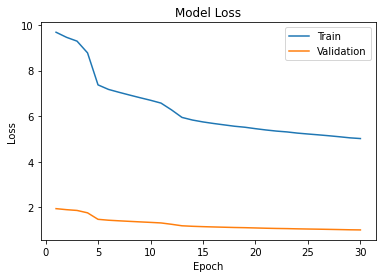

Final Training Loss: 5.02013685485969
Final Validation Loss: 1.0128971657832153


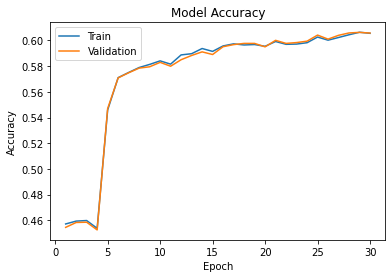

Final Training Accuracy: 0.6055870771711158
Final Validation Accuracy: 0.6057942708333334


'\nDecreasing the batch size was detrimental. While the training and validation accuracies remained the same, the respective losses greatly increased.\n'

In [ ]:
"""
To start off, I will reduce the batch size to 32 to see if making the gradient descent more sharp and prone to changes helps train the model more accurately
"""

batch_size=32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1, shuffle=True)

autoencoder1 = AutoEncoder()
if use_cuda and torch.cuda.is_available():
    autoencoder1 = autoencoder1.cuda()
    print("CUDA Available! Using GPU...")

train(autoencoder1, train_loader, valid_loader, num_epochs=30, learning_rate=1e-4)

"""
Decreasing the batch size increased the training and validation accuracies by around 1% but the respective losses also greatly increased
"""

CUDA Available! Using GPU...
COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
1 		 0.343425418 		  1.7574559 		 0.342845775 		  0.3707812
2 		 0.401613803 		  0.9712609 		 0.399414062 		  0.2048662
3 		 0.457182278 		  0.5939752 		 0.454535590 		  0.1253373
4 		 0.457182278 		  0.5737984 		 0.454535590 		  0.1210543
5 		 0.459871950 		  0.5688105 		 0.458514178 		  0.1199860
6 		 0.461995783 		  0.5657933 		 0.460611979 		  0.1193612
7 		 0.461468701 		  0.5631714 		 0.459997106 		  0.1188085
8 		 0.459848696 		  0.5607366 		 0.458550347 		  0.1183007
9 		 0.459848696 		  0.5583016 		 0.458550347 		  0.1177862
10 		 0.459631662 		  0.5554402 		 0.458080150 		  0.1171772
11 		 0.453446191 		  0.5516962 		 0.451967593 		  0.1163817
12 		 0.459848696 		  0.5456241 		 0.458550347 		  0.1150887
13 		 0.459864199 		  0.5271106 		 0.458550347 		  0.1111446
14 		 0.518773447 		  0.4810918 		 0.517686632 		  0.1013741
15 		 0.523625709 		  0.4509590 		 0.52

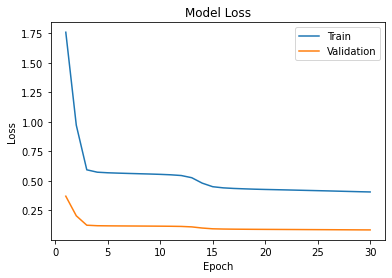

Final Training Loss: 0.40660178158727905
Final Validation Loss: 0.08553849448799156


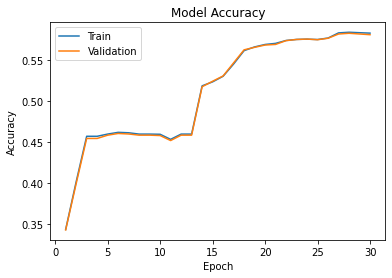

Final Training Accuracy: 0.5831473041267479
Final Validation Accuracy: 0.5812355324074074


'\nIncreasing the batch size was detrimental. The training and validation accuracy drastically decreased.\n'

In [ ]:
"""
Now, I want to do the opposite and see if a large batch size of 128 will be beneficial due to the reduced sensitivity to noise.
"""

batch_size=128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1, shuffle=True)

autoencoder2 = AutoEncoder()
if use_cuda and torch.cuda.is_available():
    autoencoder2 = autoencoder2.cuda()
    print("CUDA Available! Using GPU...")

train(autoencoder2, train_loader, valid_loader, num_epochs=30, learning_rate=1e-4)

"""
Increasing the batch size was detrimental. The training and validation accuracy decreased by around 1%.
Also note the lengthy plateau in accuracy and loss between epochs 3-13; other models did not have this characteristic.
However, other cases had a short plateau between epoch 2-6.
"""

CUDA Available! Using GPU...
COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
1 		 0.453973274 		  2.1731573 		 0.453739873 		  0.4509222
2 		 0.582434192 		  1.6668829 		 0.582031250 		  0.3450199
3 		 0.587433727 		  1.5890079 		 0.587999132 		  0.3289325
4 		 0.599920938 		  1.5001118 		 0.596535012 		  0.3118798
5 		 0.599417108 		  1.3070409 		 0.597149884 		  0.2718952
6 		 0.608718569 		  1.2583808 		 0.609483507 		  0.2620715
7 		 0.611307475 		  1.2089429 		 0.610387731 		  0.2518142
8 		 0.621918891 		  1.1683229 		 0.619972512 		  0.2433367
9 		 0.618888165 		  1.1357027 		 0.616210938 		  0.2365739
10 		 0.622438223 		  1.1047669 		 0.620949074 		  0.2300872
11 		 0.628166372 		  1.0462250 		 0.623553241 		  0.2179000
12 		 0.617500698 		  0.9964991 		 0.612702546 		  0.2076429
13 		 0.615167581 		  0.9414484 		 0.611219618 		  0.1965332
14 		 0.609152637 		  0.9116267 		 0.606011285 		  0.1901150
15 		 0.617314668 		  0.8858288 		 0.61

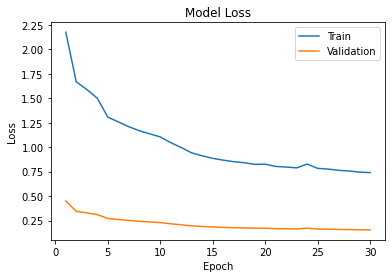

Final Training Loss: 0.7405244682975594
Final Validation Loss: 0.15528062907105777


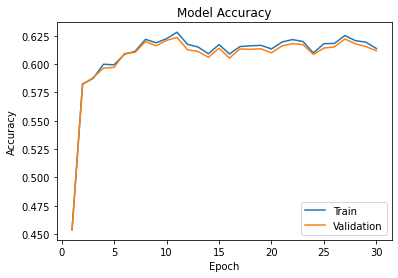

Final Training Accuracy: 0.6138033671286391
Final Validation Accuracy: 0.6118344907407407


'\nIncreasing the learning rate seemed to slightly increase the training and validation accuracies.\n'

In [ ]:
"""
Now I want to study how increasing the learning rate will affect the model's accuracy and loss.
Decreasing it seems counter-productive as it is already so small so that case will not be considered.
"""

batch_size=64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1, shuffle=True)

autoencoder3 = AutoEncoder()
if use_cuda and torch.cuda.is_available():
    autoencoder3 = autoencoder3.cuda()
    print("CUDA Available! Using GPU...")

train(autoencoder3, train_loader, valid_loader, num_epochs=30, learning_rate=0.001)

"""
Increasing the learning rate seemed to slightly increase the training and validation accuracies; up 2% from the base case. The losses also decreased.
"""

CUDA Available! Using GPU...
COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
1 		 0.554064738 		  1.6798752 		 0.554832176 		  0.3480083
2 		 0.590828760 		  1.1683950 		 0.590458623 		  0.2423726
3 		 0.614353704 		  0.9141647 		 0.610785590 		  0.1902885
4 		 0.616353518 		  0.7965716 		 0.613281250 		  0.1660729
5 		 0.622593247 		  0.7302704 		 0.620804398 		  0.1521618
6 		 0.620531423 		  0.6953764 		 0.617549190 		  0.1450139
7 		 0.613687099 		  0.6611045 		 0.612340856 		  0.1381704
8 		 0.624585310 		  0.6300470 		 0.621853299 		  0.1318819
9 		 0.623391622 		  0.6055480 		 0.619321470 		  0.1267145
10 		 0.628693455 		  0.5759686 		 0.625759549 		  0.1205953
11 		 0.627817567 		  0.5527869 		 0.623372396 		  0.1158174
12 		 0.627282733 		  0.5294368 		 0.625180845 		  0.1107044
13 		 0.629460825 		  0.5115051 		 0.629593461 		  0.1066869
14 		 0.636452423 		  0.5019615 		 0.635597512 		  0.1047536
15 		 0.633607726 		  0.4943055 		 0.63

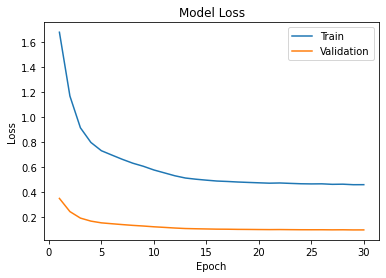

Final Training Loss: 0.45819501130421075
Final Validation Loss: 0.09568100013711955


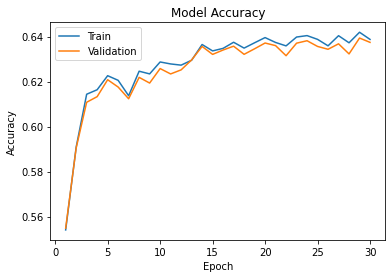

Final Training Accuracy: 0.6387157783772052
Final Validation Accuracy: 0.6374059606481481


'\nThis is objectively the best model so far. Training and validation accuracies increased to 63% while the respective losses decreased.\n'

In [35]:
"""
I have concluded that the best batch size and learning rate, based on my tests, are 64 and 0.001 respectively.
Now, I will test whether using one less layer will help improve model performance (prevent overfitting).
The ReLU layers are removed because I think they are unnecessary.
"""

batch_size=64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1, shuffle=True)

class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 34),
            nn.Linear(34, 11),
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 34),
            nn.Linear(34, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder4 = AutoEncoder2()
if use_cuda and torch.cuda.is_available():
    autoencoder4 = autoencoder4.cuda()
    print("CUDA Available! Using GPU...")

train(autoencoder4, train_loader, valid_loader, num_epochs=30, learning_rate=0.001)

"""
This is objectively the best model so far. Training and validation accuracies increased to 64% while the respective losses decreased.
"""

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [36]:
test_acc, test_loss = evaluate(autoencoder4, test_loader, nn.MSELoss())

print("Test Accuracy: %s%%" %(test_acc*100))
print("Test Loss: %s" %(test_loss))

Test Accuracy: 63.66102430555556%
Test Loss: 0.0949681157071609


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [37]:
# determine most common value for each feature in the training set
common = {}
for i in df_not_missing[:train_index].columns:
  if i not in ["age",	"yredu", "capgain",	"caploss",	"workhr"]:
    common[i] = df_not_missing[:train_index][i].mode()[0]

"""
Total Probability Law tells us that for k outcome events with probabilities n, labelled n1,n2,...,nk, the probability of the outcome occuring is sum(ni/k) where i is in [1,k]
In other words, since the event of determining the percentage of records that are correctly predicted by the baseline model is independent of the features,
  we average the individual probabilities to determine the likelihood of the baseline model correctly predicting records in the testing set. 
"""

# compute percentage of records that have the most common value for a particular feature, for each feature, in the testing set
accum = 0 # sum varaible to store sum of probabilities
for col in catcols:
  accum += len(df_not_missing[val_index:].loc[df_not_missing[val_index:][col] == common[col]])/len(df_not_missing[val_index:])*100 # compute percentage of records
accum /= len(catcols) # divide by the number of features

print("Testing accuracy for the baseline model is %s%%" %accum)

Testing accuracy for the baseline model is 46.354166666666664%


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [38]:
diff = test_acc*100 - accum
print("The testing accuracy of the neural network is %s%% higher than the testing accuracy of the baseline model" %diff)

"""
It makes sense that the neural network has a higher testing accuracy because unlike the baseline model, it does not assume that each record's features are the most common values.
"""

The testing accuracy of the neural network is 17.306857638888893% higher than the testing accuracy of the baseline model


"\nIt makes sense that the neural network has a higher testing accuracy because unlike the baseline model, it does not assume that each record's features are the most common values.\n"

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [39]:
print(df_not_missing.iloc[val_index])

"""
One may make rough estimates about a given record's education (e.g. a Private in the Army likely only graduated from High School);
  however, the utilised dataset ignores other factors such as race and socio-economic background which affect one's education level.
As such, it is not reasonable for a human to predict a given record's education without having access to these biases.
"""

age                    0.488889
yredu                    0.8125
capgain                       0
caploss                       0
workhr                 0.454545
work                    Private
marriage          Never-married
occupation       Prof-specialty
edu                   Bachelors
relationship      Not-in-family
sex                      Female
Name: 27666, dtype: object


"\nOne may make rough estimates about a given record's education (e.g. a Private in the Army likely only graduated from High School);\n  however, the utilised dataset ignores other factors such as race and socio-economic background which affect one's education level.\nAs such, it is not reasonable for a human to predict a given record's education without having access to these biases.\n"

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [40]:
record = [i for i in torch.utils.data.DataLoader(test_set[0], batch_size=64, num_workers=1)][0].cuda()
zeroed = record.clone()
start = cat_index["edu"]
end = start + len(cat_values["edu"])
zeroed[start:end] = 0
out = autoencoder4(zeroed)
pred = get_feature(out.cpu().detach().numpy(), "edu")
corr = get_feature(record.cpu().detach().numpy(), "edu")
print("The neural network model predicts this person's education level is %s" %pred)
print("The actual education level is %s" %corr)

The neural network model predicts this person's education level is Bachelors
The actual education level is Bachelors


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [41]:
lvl = common["edu"]

print("The baseline model predicts this person's education level is %s" %lvl)
print("The actual education level is %s" %corr)

The baseline model predicts this person's education level is  HS-grad
The actual education level is Bachelors
